# Doodles using DCGAN (Deep Convolutional GAN)

Unsupervised learning to create doodle images

DCGAN Paper : https://arxiv.org/pdf/1511.06434.pdf

# Import Dependencies

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Data Download

Dataset used : [Google Quickdraw Dataset](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?prefix=&forceOnObjectsSortingFiltering=false)



In [ ]:
import gdown

!gdown --id 1LZlfNkzyZBjGZ_FIdkYfjK8nMs1J-Fxm

Downloading...
From: https://drive.google.com/uc?id=1LZlfNkzyZBjGZ_FIdkYfjK8nMs1J-Fxm
To: /content/full_numpy_bitmap_birthday cake.npy
114MB [00:03, 31.8MB/s]


# Data Load
First trying to generate ***birthday cake*** doodle

In [ ]:
train_images = np.load('/content/full_numpy_bitmap_birthday cake.npy')          # load the data

In [ ]:
train_images.shape
# number of sample = first dimension
# images are 28*28 , but flattened. So the 2nd dimension is 784

(144982, 784)

# Data Resize

In [ ]:
# resizing images for CNN
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(train_images.shape)

(144982, 28, 28, 1)


# Batch

In [ ]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

From the paper - 

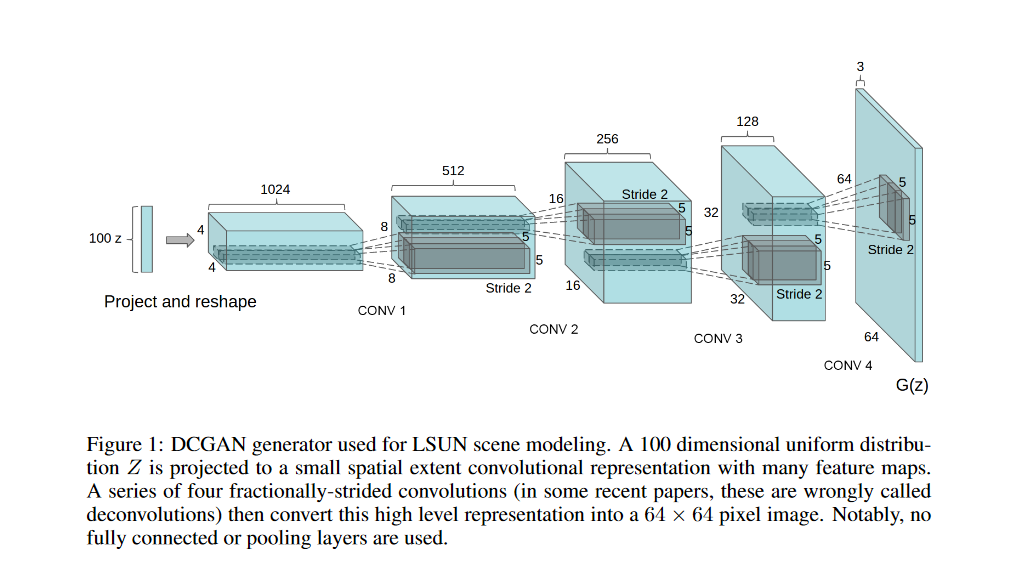

Adding a densely-connected layer to the model will take as input arrays of shape `(*, 100)`. The shape of the data will be `(*, 7*7*256)` after the first layer. Note that here we are using different size convolutions from the original paper beacuse our target image is `28 * 28`. So we will upsample in this format `7 * 7` -> `14 * 14` -> `28 * 28`

`ReLU` is linear for all positive values and set to zero for all negative values. `Leaky ReLU` has a smaller slope for negative values, instead of altogether zero.

- **First Layer** : The generator uses a `transposed convolutional layer` (upsampling) to produce an image from seed (random noise). Details about transposed convolution layer in [here](https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967)
    - 128 is the dimensionality of the output space
    - (5,5) specifies the height and width of the 2D convolution window
    - Strides = (1,1)

Here, filter = 128 , so there are 128 different sliding blocks, Each of these 128 sliding blocks produce separate output channel. That's why output shape has dimension 128.

- **Second Layer** :
    - 64 is the dimensionality of the output space
    - (5,5) specifies the height and width of the 2D convolution window
    - Strides = (2,2). 
    
In transposed convolutions, the strides parameter indicates how fast the kernel moves on the output layer. So, output hight and width will increase to (14,14)

- **Third Layer** :
    - 1 is the dimensionality of the output space (as not RGB images)
    - (5,5) specifies the height and width of the 2D convolution window
    - Strides = (2,2)

In [ ]:
def make_generator_model():
    ## using keras sequential API
    model = tf.keras.Sequential() 
    ## use_bias: Boolean, whether the layer uses a bias vector.
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

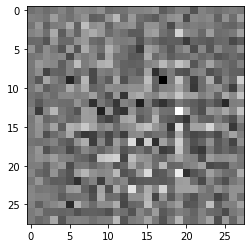

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise.shape)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Discriminator

Discriminator is a classic CNN image classifier

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

he model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00102237]], shape=(1, 1), dtype=float32)


# Loss and Optimizer

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Checkpoint

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Config

In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
## Helper function to generate and save images

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

# Restore Checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

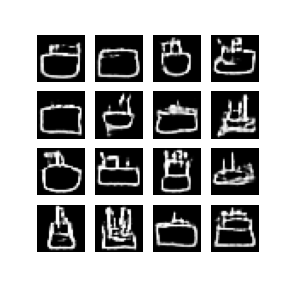

In [ ]:
display_image(30)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lcil_euc
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-lcil_euc
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0cefa2f092b60fa8b89a1fbea3d4f029b3bd65b9a_-py3-none-any.whl size=154264 sha256=02bbe8a0e4504be22f4e2efd00e4937104a367e53f49ceac321b18a1f9a9eab4
  Stored in directory: /tmp/pip-ephem-wheel-cache-1g365qcr/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.



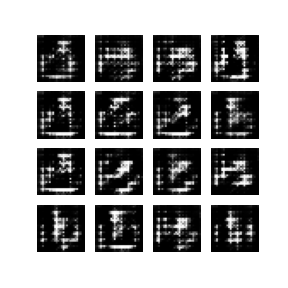

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)